In [1]:
import jax
import jax.numpy as np
from jax import lax
from jax import scipy
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro_stein.autoguides import AutoDelta
from numpyro_stein.util import init_with_noise
import numpyro_stein.stein.kernels as kernels
from numpyro_stein.stein.stein import SVGD
from numpyro.infer import ELBO
from numpyro.infer.util import init_to_value
import numpy as onp

In [2]:
class Sine(dist.Distribution):
    support = constraints.real
    def __init__(self, alpha=np.array(1.), sigma1=np.array(3e-3), sigma2=np.array(1.0), validate_args=None):
        batch_shape = lax.broadcast_shapes(np.shape(alpha), np.shape(sigma1), np.shape(sigma2))
        self.alpha = np.broadcast_to(alpha, batch_shape)
        self.sigma1 = np.broadcast_to(sigma1, batch_shape)
        self.sigma2 = np.broadcast_to(sigma2, batch_shape)
        super(Sine, self).__init__(batch_shape=batch_shape, validate_args=validate_args)

    def log_prob(self, value):
        return - (value[..., 1] + np.sin(self.alpha * value[..., 0])) ** 2 / (2 * self.sigma1) -\
                (value[..., 0] ** 2 + value[..., 1] ** 2) / (2 * self.sigma2)

    def sample(self, key, sample_shape=()):
        xs = np.array(onp.linspace(-1, 1, num=100))
        ys = np.array(onp.linspace(-1, 1, num=100))
        zs = np.stack(np.meshgrid(xs, ys), axis=-1)
        logits = np.expand_dims(np.ravel(self.log_prob(zs)), axis=0)
        cs = dist.Categorical(logits=logits).sample(key, sample_shape)
        res = np.concatenate(np.divmod(cs, zs.shape[0]), axis=-1).astype('float') /\
              np.array([np.max(xs) - np.min(xs), np.max(ys) - np.min(ys)]) + np.array([np.min(xs), np.min(ys)])
        return res

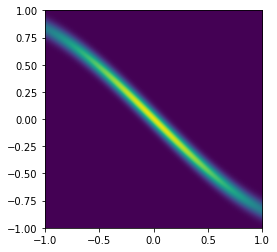

In [3]:
sine_xs = np.linspace(-1, 1, num=100)
sine_ys = np.linspace(-1, 1, num=100)
sine_zs = np.stack(np.meshgrid(sine_xs, sine_ys), axis=-1)
sine_lps = np.exp(Sine().log_prob(sine_zs))
plt.imshow(sine_lps, origin='lower', interpolation='bicubic', extent=[np.min(sine_xs), np.max(sine_xs), 
                                                                      np.min(sine_ys), np.max(sine_ys)])
plt.show()

In [4]:
class DoubleBanana(dist.Distribution):
    support = constraints.real
    def __init__(self, y=np.log(30.), sigma1=np.array(1.0), sigma2=np.array(9e-2), validate_args=None):
        batch_shape = lax.broadcast_shapes(np.shape(y), np.shape(sigma1), np.shape(sigma2))
        self.y = np.broadcast_to(y, batch_shape)
        self.sigma1 = np.broadcast_to(sigma1, batch_shape)
        self.sigma2 = np.broadcast_to(sigma2, batch_shape)
        super(DoubleBanana, self).__init__(batch_shape=batch_shape, validate_args=validate_args)
    
    def log_prob(self, value):
        fx = np.log((1 - value[..., 0]) ** 2.0 + 100 * (value[..., 1] - value[..., 0] ** 2.0) ** 2.0)
        return - np.sqrt(value[..., 0] ** 2.0 + value[..., 1] ** 2.0) ** 2.0 / (2.0 * self.sigma1) -\
                 (self.y - fx) ** 2.0 / (2.0 * self.sigma2)

    
    def sample(self, key, sample_shape=()):
        xs = np.array(onp.linspace(-1.5, 1.5, num=100))
        ys = np.array(onp.linspace(-1, 2, num=100))
        zs = np.stack(np.meshgrid(xs, ys), axis=-1)
        logits = np.expand_dims(np.ravel(self.log_prob(zs)), axis=0)
        cs = dist.Categorical(logits=logits).sample(key, sample_shape)
        res = np.concatenate(np.divmod(cs, zs.shape[0]), axis=-1).astype('float') /\
              np.array([np.max(xs) - np.min(xs), np.max(ys) - np.min(ys)]) + np.array([np.min(xs), np.min(ys)])
        return res

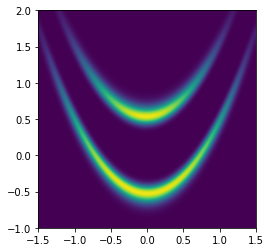

In [5]:
xs = np.linspace(-1.5, 1.5, num=100)
ys = np.linspace(-1, 2, num=100)
zs = np.stack(np.meshgrid(xs, ys), axis=-1)
lps = np.exp(DoubleBanana().log_prob(zs))
plt.imshow(lps, origin='lower', interpolation='bicubic', extent=[np.min(xs), np.max(xs), np.min(ys), np.max(ys)])
plt.show()

In [35]:
class Star(dist.Distribution):
    support = constraints.real
    def __init__(self, mu0=np.array([0., 1.5]), cov0=np.diag(np.array([1e-2, 0.25])), n_comp=5, validate_args=None):
        batch_shape = lax.broadcast_shapes(np.shape(mu0)[:-1], np.shape(cov0)[:-2])
        mu0 = np.broadcast_to(mu0, batch_shape + np.shape(mu0)[-1:])
        cov0 = np.broadcast_to(cov0, batch_shape + np.shape(cov0)[-2:])
        self.n_comp = n_comp
        mus = [mu0]
        covs = [cov0]
        theta = 2 * np.pi / n_comp
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        for i in range(n_comp - 1):
            mui = rot @ mus[-1]
            covi = rot @ covs[-1] @ rot.transpose()
            mus.append(mui)
            covs.append(covi)
        self.mus = np.stack(mus)
        self.covs = np.stack(covs)
        super(Star, self).__init__(batch_shape=batch_shape, validate_args=validate_args)
    
    def log_prob(self, value):
        lps = []
        for i in range(self.n_comp):
            lps.append(dist.MultivariateNormal(self.mus[i], self.covs[i]).log_prob(value))
        return scipy.special.logsumexp(np.stack(lps, axis=0), axis=0) / self.n_comp

    def sample(self, key, sample_shape=()):
        print(key)
        zs = dist.Categorical(probs=np.array([1/self.n_comp] * self.n_comp)).sample(key, sample_shape)
        xs = np.stack([dist.MultivariateNormal(self.mus[i], self.covs[i]).sample(key, sample_shape) 
                       for i in range(self.n_comp)], axis=0)
        return np.take_along_axis(xs, np.expand_dims(np.expand_dims(zs, axis=-1), axis=-1), axis=0)

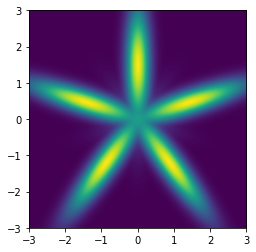

In [7]:
xs = np.linspace(-3, 3, num=100)
ys = np.linspace(-3, 3, num=100)
zs = np.stack(np.meshgrid(xs, ys), axis=-1)
lps = np.exp(Star().log_prob(zs))
plt.imshow(lps, origin='lower', interpolation='bicubic', extent=[np.min(xs), np.max(xs), np.min(ys), np.max(ys)])
plt.show()

In [8]:
rng_key = jax.random.PRNGKey(42)

# Sine Model

In [9]:
num_iterations = 30

In [10]:
def model():
    numpyro.sample('x', Sine())
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value({'x': np.array([0., 0.])}), noise_scale=1.0))

In [11]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=0.5), ELBO(),
            kernels.RBFKernel(), num_stein_particles=50, num_loss_particles=1)

[ 895026564 2266944918]
[1103547586 3522086544]
SVGD 5.3147: 100%|██████████| 30/30 [00:12<00:00,  2.35it/s]


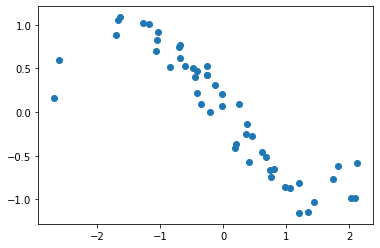

In [12]:
svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

In [13]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
            kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='const'),
            num_stein_particles=50, num_loss_particles=1)

[1103547586 3522086544]
SVGD 14.371: 100%|██████████| 30/30 [00:09<00:00,  3.28it/s]


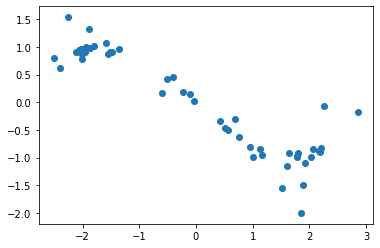

In [14]:
svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

In [15]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=0.5), ELBO(),
            kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='anchor_points'),
            num_stein_particles=50, num_loss_particles=1)

[1103547586 3522086544]
SVGD 9.3697: 100%|██████████| 30/30 [00:12<00:00,  2.33it/s]


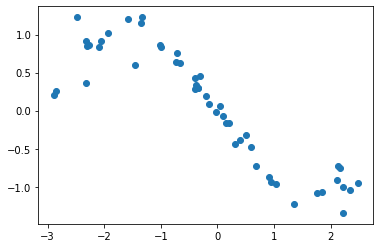

In [16]:
svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

# Double Banana Model

In [17]:
num_iterations = 100

In [18]:
def model():
    numpyro.sample('x', DoubleBanana())
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value({'x': np.array([0., 0.])}), noise_scale=3.0))

In [19]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
            kernels.RBFKernel(), num_stein_particles=50, num_loss_particles=1)

SVGD 6.4919: 100%|██████████| 100/100 [00:06<00:00, 15.72it/s]


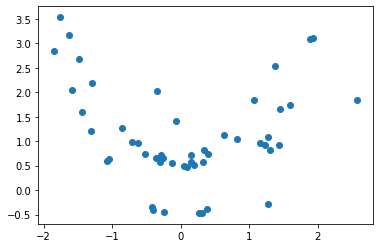

In [20]:
svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

In [21]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
            kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='const'),
            num_stein_particles=50, num_loss_particles=1)

SVGD 4.8154: 100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


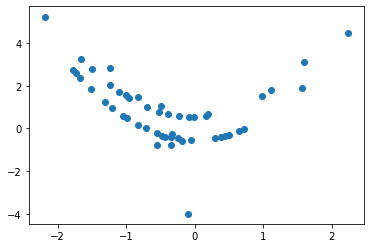

In [22]:
svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

In [23]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=.8), ELBO(),
            kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='anchor_points'),
            num_stein_particles=50, num_loss_particles=1)

SVGD 4.0935: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


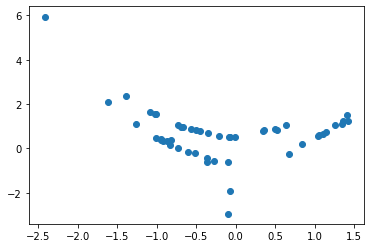

In [24]:
svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

# Star Model

In [25]:
num_iterations = 60

In [26]:
def model():
    numpyro.sample('x', Star())
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value({'x': np.array([0., 0.])}), noise_scale=3.0))

In [27]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
            kernels.RBFKernel(), num_stein_particles=50, num_loss_particles=1)

SVGD 0.55555: 100%|██████████| 60/60 [00:07<00:00,  7.51it/s]


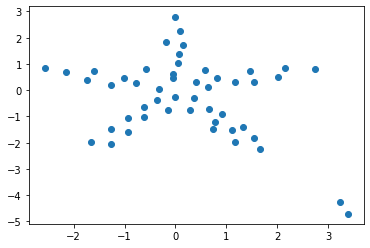

In [28]:
svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

In [29]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=0.5), ELBO(),
            kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='const'),
            num_stein_particles=50, num_loss_particles=1)

SVGD 1.552: 100%|██████████| 60/60 [00:20<00:00,  2.95it/s]


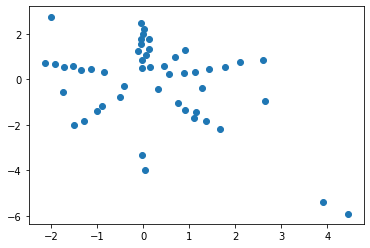

In [30]:
svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

In [31]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=0.8), ELBO(),
            kernels.PrecondMatrixKernel(kernels.HessianPrecondMatrix(), kernels.RBFKernel(mode='matrix'),
                                        precond_mode='anchor_points'),
            num_stein_particles=50, num_loss_particles=1)

SVGD 0.43407: 100%|██████████| 60/60 [00:27<00:00,  2.17it/s]


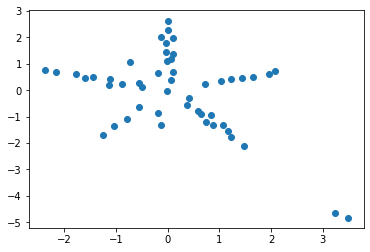

In [32]:
svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

In [33]:
svgd = SVGD(model, guide, numpyro.optim.Adagrad(step_size=0.8), ELBO(),
            kernels.RBFKernel(),
            num_stein_particles=50, num_loss_particles=1,
            num_mcmc_particles=5)

In [36]:
with jax.disable_jit():
    svgd_state, loss = svgd.run(rng_key, num_iterations)
res = svgd.get_params(svgd_state)['auto_x']
plt.clf()
plt.scatter(res[..., 0], res[..., 1])

[1103547586 3522086544]
  0%|          | 0/60 [00:00<?, ?it/s]None



TypeError: _random_bits got invalid prng key.